In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import CIFAR10
from torchvision import transforms

In [2]:
transform = transforms.Compose(
    [
        transforms.ToTensor(), 
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

trainset = CIFAR10(root='~/data',  train=True, download=True, transform=transform)
train_dl = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testset = CIFAR10(root='~/data', train=False, download=True, transform=transform)
test_dl = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

print(len(train_dl), len(test_dl))

Files already downloaded and verified
Files already downloaded and verified
782 157


In [3]:
class BasicBlock(nn.Module):
    def __init__(self, channel_num):
        super(BasicBlock, self).__init__()
        self.conv_block1 = nn.Sequential(
			nn.Conv2d(channel_num, channel_num, 3, padding=1),
			nn.BatchNorm2d(channel_num),
			nn.ReLU(),
		)
        self.conv_block2 = nn.Sequential(
			nn.Conv2d(channel_num, channel_num, 3, padding=1),
			nn.BatchNorm2d(channel_num),
		)
        self.relu = nn.ReLU()
        torch.nn.init.kaiming_normal_(self.conv_block1[0].weight)
        torch.nn.init.kaiming_normal_(self.conv_block2[0].weight)
        
    def forward(self, x):
        residual = x
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = x + residual
        out = self.relu(x)
        return out

In [4]:
class BasicTransBlock(nn.Module):
    def __init__(self, channel_num):
        super(BasicTransBlock, self).__init__()
        self.conv_block1 = nn.Sequential(
			nn.ConvTranspose2d(channel_num, channel_num, 3, padding=1),
			nn.BatchNorm2d(channel_num),
			nn.ReLU(),
		)
        self.conv_block2 = nn.Sequential(
			nn.ConvTranspose2d(channel_num, channel_num, 3, padding=1),
			nn.BatchNorm2d(channel_num),
		)
        self.relu = nn.ReLU()
        torch.nn.init.kaiming_normal_(self.conv_block1[0].weight)
        torch.nn.init.kaiming_normal_(self.conv_block2[0].weight)
        
    def forward(self, x):
        residual = x
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = x + residual
        out = self.relu(x)
        return out

In [5]:
class Cifar10_ResNetAE(nn.Module):
    def __init__(self, in_channels = 3, type = 18):
        super(Cifar10_ResNetAE, self).__init__()
        self.struc_dict = {
            18: {
                "num_channels" : [12, 24, 48],
                "counts" : [1, 1, 1]
            }
        }
        channel_init = self.struc_dict[type]["num_channels"][0]
        self.conv_in = nn.Conv2d(in_channels=in_channels, out_channels=channel_init, kernel_size=7, stride=1)
        torch.nn.init.kaiming_normal_(self.conv_in.weight)
        self.max_in = nn.MaxPool2d(2)

        num_channels = self.struc_dict[type]["num_channels"]
        counts = self.struc_dict[type]["counts"]
        inv_num_channels = self.struc_dict[type]["num_channels"][::-1]
        
        self.encoder = nn.Sequential()
        for idx, struc in enumerate(
            zip(
                num_channels, 
                counts
            )
        ):
            num_channel, cnt = struc
            for i in range(cnt):
                self.encoder.add_module(f"conv{idx}_{i}", BasicBlock(num_channel))
            if idx < len(num_channels) - 1:
                self.encoder.add_module(
                    f"conv_switch{idx}_{idx+1}", nn.Conv2d(num_channel, num_channels[idx+1], 3, 1)
                )
                self.encoder.add_module(
                    f"bn{idx}_{idx+1}", nn.BatchNorm2d(num_channels[idx+1])
                )
        self.dw_latent = nn.Sequential(
            nn.Flatten(1),
            nn.Linear(9 * 9 * 48, 256),
        )
        
        self.latent = nn.Linear(256, 256)
        
        self.up_latent = nn.Sequential(
            nn.Linear(128, 256),
            nn.Linear(256, 9 * 9 * 48),            
        )
        
        self.decoder = nn.Sequential()
        for idx, struc in enumerate(
            zip(
                inv_num_channels, 
                counts
            )
        ):
            num_channel, cnt = struc
            for i in range(cnt):
                self.decoder.add_module(f"deconv{idx}_{i}", BasicTransBlock(num_channel))
            if idx < len(inv_num_channels) - 1:
                self.decoder.add_module(
                    f"deconv_switch{idx}_{idx+1}", nn.ConvTranspose2d(num_channel, inv_num_channels[idx+1], 3, 1)
                )
                self.decoder.add_module(
                    f"bn{idx}_{idx+1}", nn.BatchNorm2d(inv_num_channels[idx+1])
                )

        self.up_out = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv_out = nn.ConvTranspose2d(in_channels=channel_init, out_channels=in_channels, kernel_size=7, stride=1)
        torch.nn.init.kaiming_normal_(self.conv_out.weight)
                                     
    def forward(self, x):
        x = self.conv_in(x)
        x = self.max_in(x)
        x = self.encoder(x)
        lat = self.latent(self.dw_latent(x))
        mu, lv = self.unwrap(lat)
        rec_lat = self.up_latent(self.reparam(mu, lv))
        x = self.decoder(rec_lat.view(-1, 48, 9, 9))
        x = self.up_out(x)
        x = self.conv_out(x)
        return x, mu, lv

    def unwrap(self, x):
        return torch.split(x, x.shape[1]//2, dim=1)

    def reparam(self, mu, lv):
        if self.training:
            std = torch.exp(0.5 * lv)
            eps = torch.randn_like(std)
            return mu + std * eps
        else:
            return mu

In [6]:
def gaussian_kls(mu, logvar, mean=False):

    klds = -0.5*(1 + logvar - mu.pow(2) - logvar.exp())

    if mean:
        reduce = lambda x: torch.mean(x, 1)
    else:
        reduce = lambda x: torch.sum(x, 1)

    total_kld = reduce(klds).mean(0, True)
    dimension_wise_kld = klds.mean(0)
    mean_kld = reduce(klds).mean(0, True)

    return total_kld, dimension_wise_kld, mean_kld

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)

epochs = 10

model = Cifar10_ResNetAE().to(device)

optimizer = Adam(model.parameters(), lr = 0.001)

scheduler = CosineAnnealingLR(optimizer, epochs)

loss_fn = nn.MSELoss()

In [8]:
for epoch in range(epochs):
    model.train()
    tr_total_loss = 0
    for train_img, _ in tqdm(train_dl):
        train_img = train_img.to(device)

        gen_img, train_mu, train_lv = model(train_img)
        train_rec_loss = loss_fn(gen_img, train_img)
        train_kl_loss, _, _ = gaussian_kls(train_mu, train_lv)
        train_loss = train_rec_loss + train_kl_loss

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        tr_total_loss += train_loss.item()

    model.eval()
    with torch.no_grad():
        va_total_loss = 0
        for valid_img, _ in tqdm(test_dl):
            valid_img = valid_img.to(device)

            gen_img, valid_mu, valid_lv = model(valid_img)
            valid_rec_loss = loss_fn(gen_img, valid_img)
            valid_kl_loss, _, _ = gaussian_kls(valid_mu, valid_lv)
            valid_loss = valid_rec_loss + valid_kl_loss

            va_total_loss += valid_loss.item()

    print(f"Epoch: {epoch} - TrainLoss: {tr_total_loss/len(train_dl)} - ValidLoss: {va_total_loss/len(test_dl)}")

100%|█████████████████████████████████████████████████████| 157/157 [00:00<00:00, 159.90it/s]


Epoch: 0 - TrainLoss: 0.9571015085177044 - ValidLoss: 0.25747128087244214


100%|█████████████████████████████████████████████████████| 157/157 [00:00<00:00, 163.27it/s]


Epoch: 1 - TrainLoss: 0.2547752679423298 - ValidLoss: 0.25200671422633397


100%|█████████████████████████████████████████████████████| 157/157 [00:00<00:00, 164.36it/s]


Epoch: 2 - TrainLoss: 0.2515000410358924 - ValidLoss: 0.24972035474837964


100%|█████████████████████████████████████████████████████| 157/157 [00:00<00:00, 163.44it/s]


Epoch: 3 - TrainLoss: 0.2500983351827278 - ValidLoss: 0.2487701668291335


100%|█████████████████████████████████████████████████████| 157/157 [00:00<00:00, 162.94it/s]


Epoch: 4 - TrainLoss: 0.2494358063468238 - ValidLoss: 0.24834429581833492


100%|█████████████████████████████████████████████████████| 157/157 [00:00<00:00, 164.65it/s]


Epoch: 5 - TrainLoss: 0.24898880598185313 - ValidLoss: 0.24817805618617186


100%|█████████████████████████████████████████████████████| 157/157 [00:00<00:00, 161.14it/s]


Epoch: 6 - TrainLoss: 0.24872750344941075 - ValidLoss: 0.24774584363979898


100%|█████████████████████████████████████████████████████| 157/157 [00:00<00:00, 159.73it/s]


Epoch: 7 - TrainLoss: 0.2485247340501117 - ValidLoss: 0.24763730927637428


100%|█████████████████████████████████████████████████████| 157/157 [00:00<00:00, 157.32it/s]


Epoch: 8 - TrainLoss: 0.2484287354723572 - ValidLoss: 0.24766091129202752


100%|█████████████████████████████████████████████████████| 157/157 [00:00<00:00, 161.08it/s]

Epoch: 9 - TrainLoss: 0.24829275827959676 - ValidLoss: 0.24774517356210454


In [9]:
model.eval()
with torch.no_grad():
    va_total_loss = 0
    for valid_img, _ in tqdm(test_dl):
        valid_img = valid_img.to(device)

        gen_img, valid_mu, valid_lv = model(valid_img)
        valid_rec_loss = loss_fn(gen_img, valid_img)
        valid_kl_loss, _, _ = gaussian_kls(valid_mu, valid_lv)
        valid_loss = valid_rec_loss + valid_kl_loss

        va_total_loss += valid_loss.item()

print(f"ValidLoss: {va_total_loss/len(test_dl)}")

100%|█████████████████████████████████████████████████████| 157/157 [00:00<00:00, 163.41it/s]

ValidLoss: 0.24774517356210454


  0%|                                                                 | 0/10 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 40%|██████████████████████

tensor(271.4623, device='cuda:0')
tensor(-854.3160, device='cuda:0')
tensor(-311.1696, device='cuda:0')
tensor(-847.0703, device='cuda:0')
tensor(295.9785, device='cuda:0')
tensor(526.3089, device='cuda:0')
tensor(1060.7966, device='cuda:0')
tensor(792.6559, device='cuda:0')
tensor(-966.2681, device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-590.6857, device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 44.55it/s]


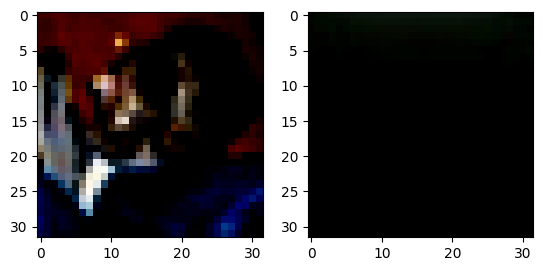

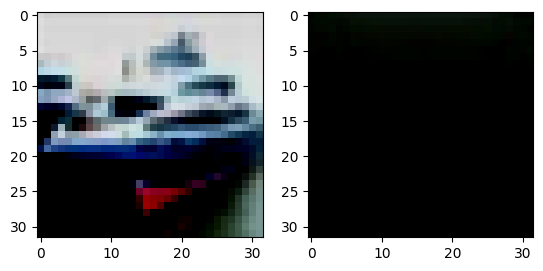

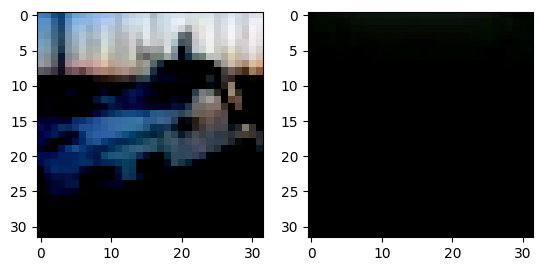

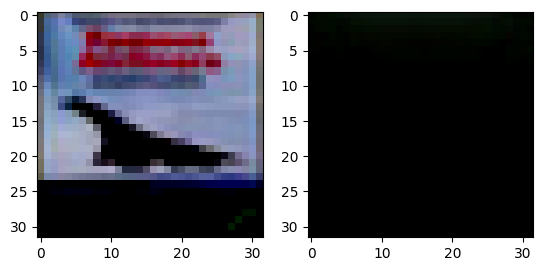

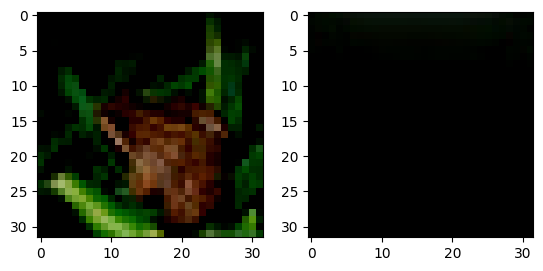

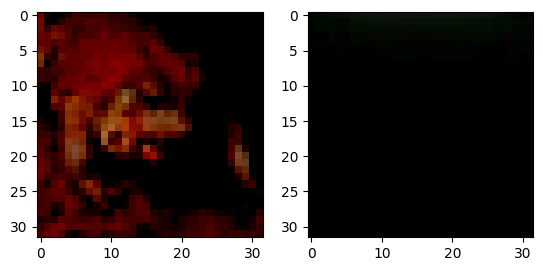

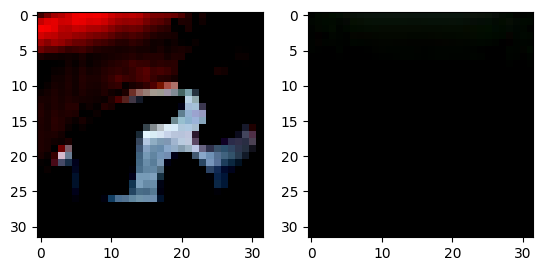

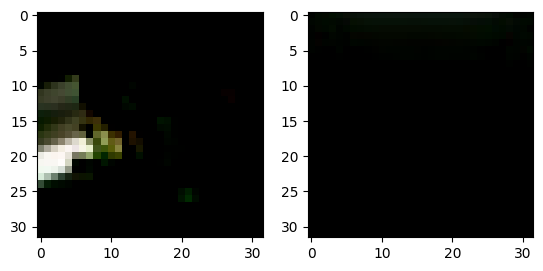

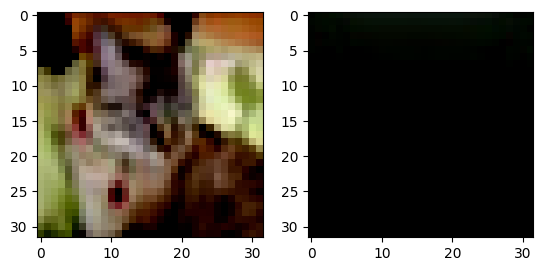

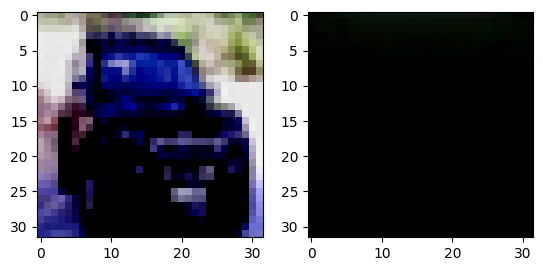

In [10]:
model.eval()
with torch.no_grad():
    for test_case_idx in tqdm(range(10)):
        valid_img, _ = testset[test_case_idx]
        valid_img = valid_img.unsqueeze(dim=0).to(device)

        gen_img, _, _ = model(valid_img)  
        print(torch.sum(gen_img - valid_img))

        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(valid_img[0].cpu().permute(1, -1, 0).numpy())
        axarr[1].imshow(gen_img[0].cpu().permute(1, -1, 0).numpy())